In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Predicting Gym Crowdedness with Stochastic Gradient Descent

Using historical data on gym usage by **day**, **hour**, and other features, we train a model that predicts how crowded the gym is likely to be. This allows us to:
- Identify low-traffic hours for efficient workouts.
- Avoid peak times with long wait lines.
- Apply machine learning in a context that's directly useful in daily life.

The model will be trained using **stochastic gradient descent (SGD)**, reinforcing key concepts from the course.

In [3]:
data = pd.read_csv("crowdness_gym_data.csv")

In [4]:
data.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


## Dataset Overview

The dataset contains over **60,000 observations** related to gym usage, capturing when and under what conditions the gym was crowded.

### Target Variable
- **`number_people`**: The number of people present at the gym. This is our **target variable** for prediction.

### Features
- **`date`**: Full date and time as a string.
- **`timestamp`**: Seconds since midnight (00:00).
- **`day_o_fweek`**: Integer from 0 (Monday) to 6 (Sunday).
- **`is_weekend`**: Boolean indicating if the observation occurred on a weekend.
- **`is_holiday`**: Boolean indicating if the observation occurred on a holiday.
- **`temperature`**: Temperature (°F) at the time of observation.
- **`is_startof_semester`**: Boolean indicating if it's within the first two weeks of the semester.
- **`is_during_semester`**: Boolean indicating if it's during an active semester.
- **`month`**: Integer from 1 (January) to 12 (December).
- **`hour`**: Hour of the day (0 to 23).

These features provide a rich set of contextual signals to help predict gym crowdedness based on **time, calendar events, and environmental conditions**.


## Exploratory Data Analysis (EDA) and Data Cleaning

Before building our predictive model, we perform exploratory analysis and clean the dataset to ensure that it’s suitable for training.

### Goals:
- **Understand feature distributions** and relationships with the target (`number_people`).
- **Visualize patterns** across time, weekdays, hours, and other features.
- **Remove or transform noisy data** that could hurt model performance.
- **Select features** that are realistically available when making a future prediction.

### Considerations:
Since our goal is to predict gym crowdedness based on **readily available information** (e.g., hour, day, holiday status), we need to ensure we only include features we could reasonably input in real time. We discard any columns that won’t be available at prediction time or add unnecessary noise.


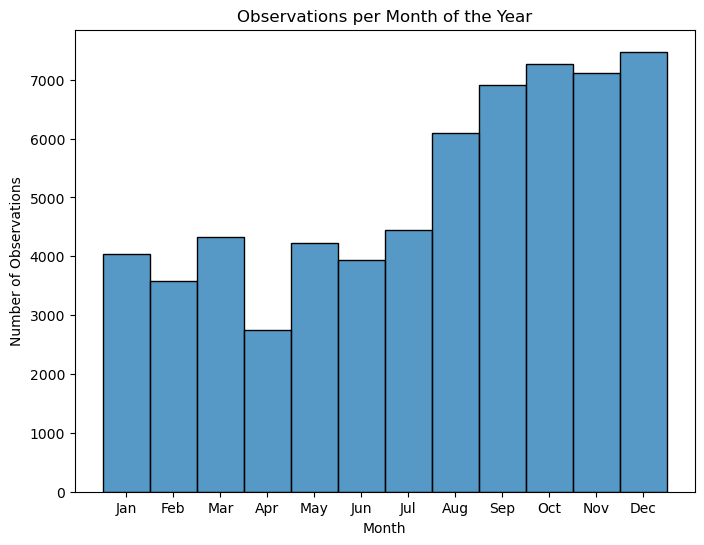

In [8]:
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(8, 6))
sns.histplot(data['month'], bins=12, discrete=True)
plt.title("Observations per Month of the Year")
plt.xlabel('Month')
plt.ylabel('Number of Observations')
plt.xticks(ticks=range(1, 13), labels=month_labels)  
plt.show()

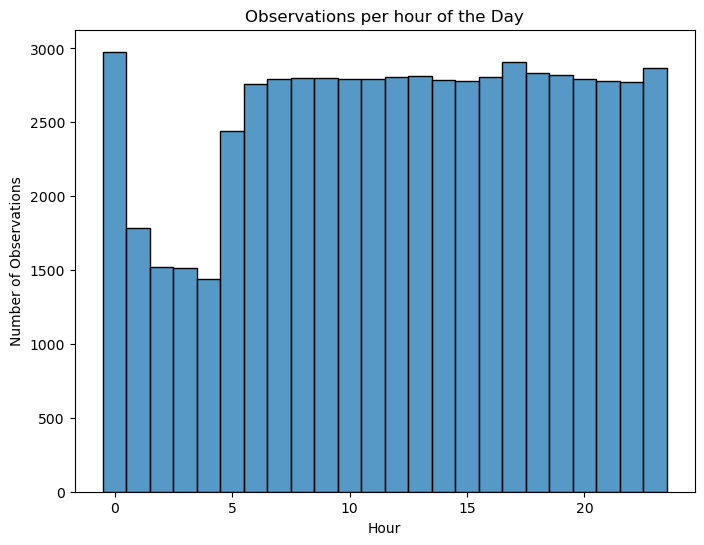

In [9]:
plt.figure(figsize=(8, 6))
sns.histplot(data['hour'], bins=7, discrete=True)
plt.title("Observations per hour of the Day")
plt.xlabel('Hour')
plt.ylabel('Number of Observations')
plt.show()

In [10]:
data = data.drop("date", axis=1)

corr = data.corr(numeric_only=True)
corr["number_people"]

number_people           1.000000
timestamp               0.550218
day_of_week            -0.162062
is_weekend             -0.173958
is_holiday             -0.048249
temperature             0.373327
is_start_of_semester    0.182683
is_during_semester      0.335350
month                  -0.097854
hour                    0.552049
Name: number_people, dtype: float64

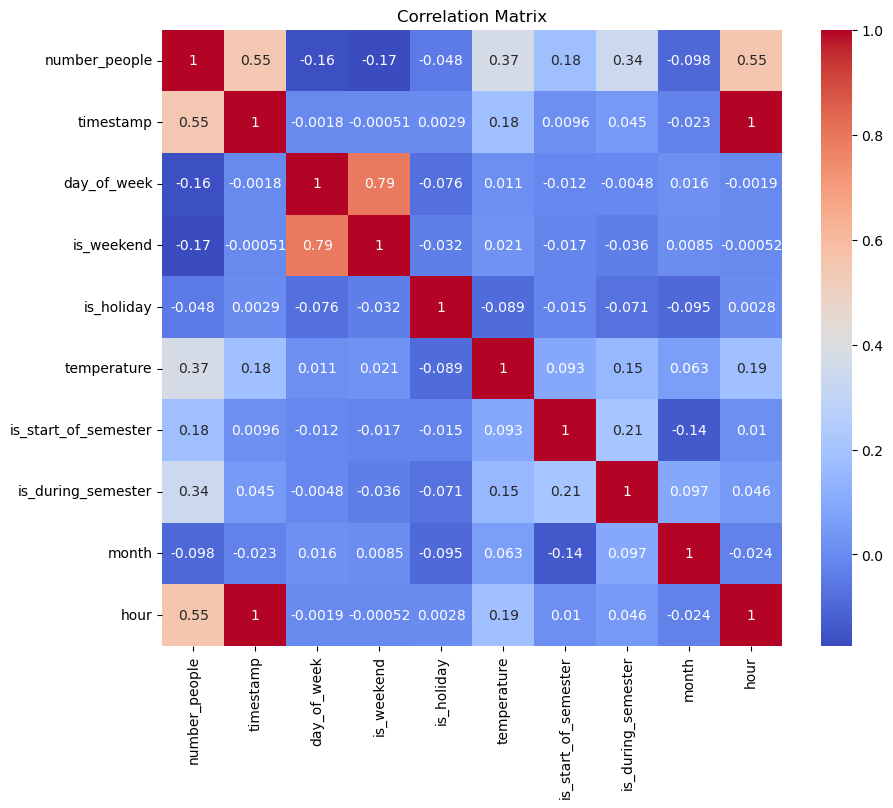

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature Selection

Based on our exploratory analysis, we selected the following features for modeling:

- **`hour`**: Clear daily patterns in gym usage, with peak hours showing higher crowdedness.
- **`temperature`**: Weather conditions may influence whether people choose to go to the gym.
- **`is_during_semester`**: Gym usage is typically higher during active academic semesters.

These features were chosen for their **predictive value** and because they are **available in real-time**, making the model practical for future use.

In [13]:
data =  data[["hour", "temperature", "is_during_semester", "number_people"]]

## Model Building, Testing, and Visualization

We now begin building and testing a **Stochastic Gradient Descent (SGD) Regressor** using the selected features.

After training the model, we evaluate its performance on the test set and visualize the results to better understand how well the model predicts gym crowdedness.

In [32]:
X = data.drop(["number_people"], axis=1)
y = data["number_people"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = SGDRegressor(alpha=0.0001, learning_rate='optimal', loss='huber', penalty='elasticnet', random_state = 42)
model.fit(X_train, y_train)

SGDRegressor(learning_rate='optimal', loss='huber', penalty='elasticnet',
             random_state=42)

In [34]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE score: {mae:.2f}")
print(f"R² score: {r2:.2f}")

MSE: 280.48
MAE score: 12.71
R² score: 0.46


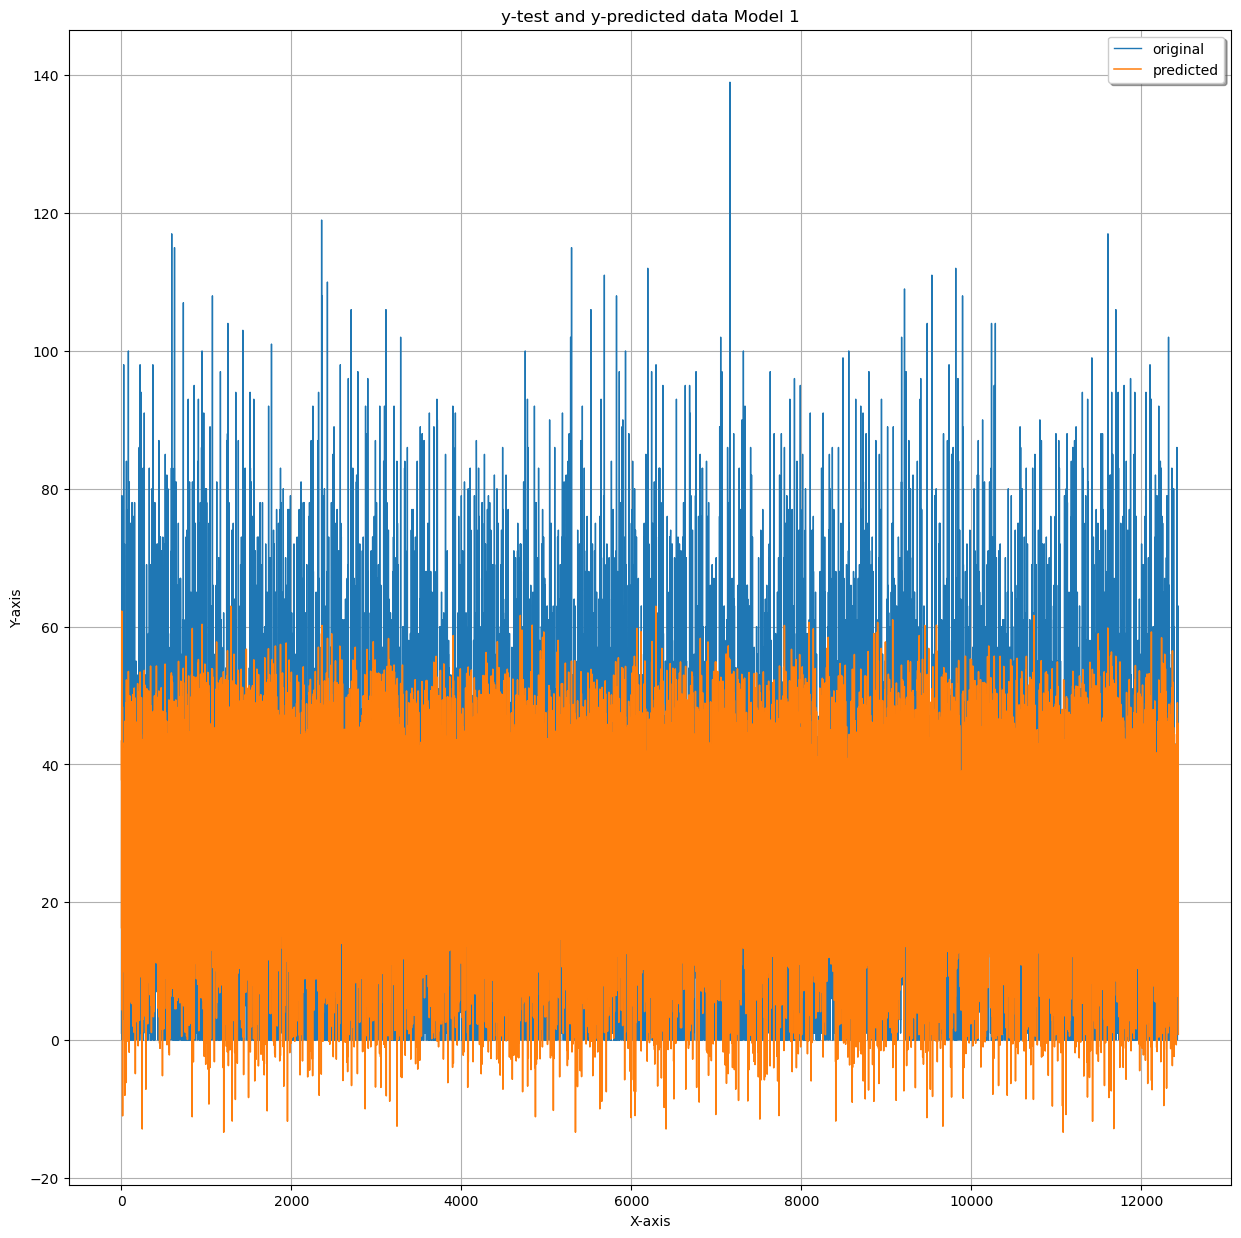

In [39]:
plt.figure(figsize=(15, 15))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data Model 1")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 